In [71]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pendulum
import os

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [49]:
save_base = r"C:\Users\jordan\Desktop\detection\analysis"

combined_df = pd.read_csv(os.path.join(save_base, "combined_df_all_training.csv"))

c104_df = combined_df[combined_df['mouseid'] == 'c104']
jlh51_df = combined_df[combined_df['mouseid'] == 'jlh51']
jlh52_df = combined_df[combined_df['mouseid'] == 'jlh52']
jlh54_df = combined_df[combined_df['mouseid'] == 'jlh54']

c104_dfx = c104_df[c104_df['autoreward'] != True]
jlh52_dfx = jlh52_df[jlh52_df['autoreward'] != True] 
jlh51_dfx = jlh51_df[jlh51_df['autoreward'] != True] 
jlh54_dfx = jlh54_df[jlh54_df['autoreward'] != True] 

c104_dfx['cont_trial_number'] = np.arange(0, len(c104_dfx))
jlh52_dfx['cont_trial_number'] = np.arange(0, len(jlh52_dfx))
jlh51_dfx['cont_trial_number'] = np.arange(0, len(jlh51_dfx))
jlh54_dfx['cont_trial_number'] = np.arange(0, len(jlh54_dfx))

c104_gratings_highc_catch = c104_dfx[(c104_dfx['grating_contrast_int'] > 70) | (c104_dfx['circle_contrast_int'] == 0)]
jlh52_gratings_highc_catch = jlh52_dfx[(jlh52_dfx['grating_contrast_int'] > 70) | (jlh52_dfx['grating_contrast_int'] == 0)]
jlh51_gratings_highc_catch = jlh51_dfx[(jlh51_dfx['grating_contrast_int'] > 70) | (jlh51_dfx['grating_contrast_int'] == 0)]
jlh54_gratings_highc_catch = jlh54_dfx[(jlh54_dfx['grating_contrast_int'] > 70) | (jlh54_dfx['grating_contrast_int'] == 0)]

c104_circle_highc_catch = c104_dfx[(c104_dfx['circle_contrast_int'] > 70) | (c104_dfx['circle_contrast_int'] == 0)]
jlh52_circle_highc_catch = jlh52_dfx[(jlh52_dfx['circle_contrast_int'] > 70) | (jlh52_dfx['circle_contrast_int'] == 0)]
jlh51_circle_highc_catch = jlh51_dfx[(jlh51_dfx['circle_contrast_int'] > 70) | (jlh51_dfx['circle_contrast_int'] == 0)]
jlh54_circle_highc_catch = jlh54_dfx[(jlh54_dfx['circle_contrast_int'] > 70) | (jlh54_dfx['circle_contrast_int'] == 0)]

C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\89118004.py:3: DtypeWarning: Columns (2,6,7,8,22,23,26,28,34,35,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(os.path.join(save_base, "combined_df_all_training.csv"))
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\89118004.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c104_dfx['cont_trial_number'] = np.arange(0, len(c104_dfx))
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\89118004.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

# functions

In [11]:
from scipy.stats import norm

def safe_rate(rate, eps=1e-5):
    # Adjust rates to avoid infinite values from norm.ppf
    if rate <= 0:
        return eps
    elif rate >= 1:
        return 1 - eps
    return rate

def calculate_dprime(df, return_hit_fa = False):
    """
    Calculate d prime using:
      hit_rate = rewarded / (rewarded + lapse)   [from non-catch trials]
      false_alarm_rate = catch_false_alarm / (catch_false_alarm + catch_lapse)   [from catch trials]
      
    d' = norm.ppf(hit_rate) - norm.ppf(false_alarm_rate)
    """
    # Compute false alarm rate using catch trials
    catch_trials = df[df['catch'] == True]
    fa_total = catch_trials['catch_false_alarm'].sum() + catch_trials['catch_lapse'].sum()
    false_alarm_rate = (catch_trials['catch_false_alarm'].sum() / fa_total) if fa_total else 0.0
    #false_alarm_rate = df['false_alarm'].sum() / len(df) if len(df) > 0 else 0.0
    
    # Compute hit rate using signal (non-catch) trials
    signal_trials = df[df['catch'] == False]
    signal_total = signal_trials['rewarded'].sum() + signal_trials['lapse'].sum()
    hit_rate = (signal_trials['rewarded'].sum() / signal_total) if signal_total else 0.0

    # Apply safe rate adjustments
    hit_rate = safe_rate(hit_rate)
    false_alarm_rate = safe_rate(false_alarm_rate)
    
    # Calculate and return d prime
    if return_hit_fa:
        return norm.ppf(hit_rate) - norm.ppf(false_alarm_rate), hit_rate, false_alarm_rate #norm.ppf(hit_rate), norm.ppf(false_alarm_rate)
    else:
      return norm.ppf(hit_rate) - norm.ppf(false_alarm_rate)

def plot_dprime_across_sessions(df, groupbycat = 'session_no', ax=None, color = 'blue'):
    """
    Plot d prime across sessions.
    
    Parameters:
      df : DataFrame
        DataFrame containing the data with a 'date' column.
      ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure and axis will be created.
        
    Returns:
      fig, ax : tuple
        The matplotlib figure and axis objects.
    """
    
    # Group by session and calculate d prime for each session
    session_stats = df.groupby(groupbycat).apply(calculate_dprime).reset_index(name='dprime')
    
    # Create a new figure and axis if one isn't provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.54,3.54))
    else:
        fig = ax.figure
    
    # Plot d prime across sessions
    ax.plot(session_stats[groupbycat], session_stats['dprime'], marker='o', markersize = 4, color = color)
    ax.set_xlabel(groupbycat)
    ax.set_ylabel("d prime")
    ax.set_title(f"d prime across {groupbycat}")
    
    return fig, ax
  
def plot_rxntimes_across_sessions(df, stat = 'mean', groupbycat = 'session_no', ax=None, color = 'blue'):
    """
    Plot d prime across sessions.
    
    Parameters:
      df : DataFrame
        DataFrame containing the data with a 'date' column.
      ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure and axis will be created.
        
    Returns:
      fig, ax : tuple
        The matplotlib figure and axis objects.
    """
    
    df_rewarded = df[(df['rewarded'] == True) & (df['catch'] == False)]
    if stat == 'mean':
      session_stats = df_rewarded.groupby(groupbycat)['reaction_time'].mean().reset_index(name='rxntimes')
    elif stat == 'variance':
      session_stats = df_rewarded.groupby(groupbycat)['reaction_time'].var().reset_index(name='rxntimes')
    elif stat == 'std':
      session_stats = df_rewarded.groupby(groupbycat)['reaction_time'].std().reset_index(name='rxntimes')    
      
      
    # Create a new figure and axis if one isn't provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.54,3.54))
    else:
        fig = ax.figure
    
    # Plot d prime across sessions
    ax.plot(session_stats[groupbycat], session_stats['rxntimes'], marker='o', markersize = 4, color = color)
    ax.set_xlabel(groupbycat)
    ax.set_ylabel(f"reaction time -- {stat}")
    ax.set_title("rxn time across Sessions")
    
    return fig, ax
  

def plot_numrewarded_across_sessions(df, ax=None, color = 'blue'):
    """
    Plot number of rewarded trials across sessions.
    
    Parameters:
      df : DataFrame
        DataFrame containing the data with a 'date' column.
      ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure and axis will be created.
        
    Returns:
      fig, ax : tuple
        The matplotlib figure and axis objects.
    """
    
    df_rewarded = df[(df['rewarded'] == True) & (df['catch'] == False)]
    session_stats = df_rewarded.groupby('session_no')['rewarded'].count().reset_index(name='numrewarded')

      
    # Create a new figure and axis if one isn't provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.54,3.54))
    else:
        fig = ax.figure
    
    # Plot d prime across sessions
    ax.plot(session_stats['session_no'], session_stats['numrewarded'], marker='o', markersize = 4, color = color)
    ax.set_xlabel("Session Number")
    ax.set_ylabel(f"Rewarded Trials Count")
    ax.set_title("")
    
    return fig, ax



# Learning

C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\1322359296.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_success'] = df['rewarded'] & rt_mask
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\1322359296.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_FP'] = df['catch_false_alarm'] & rt_mask


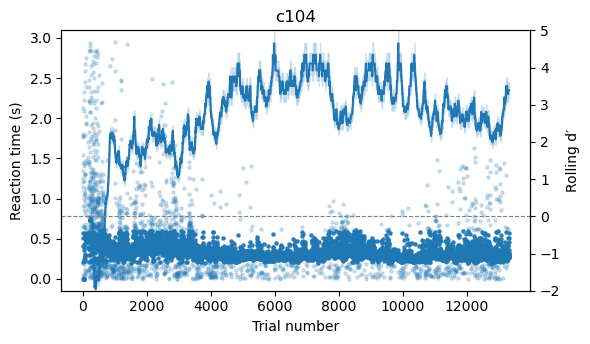

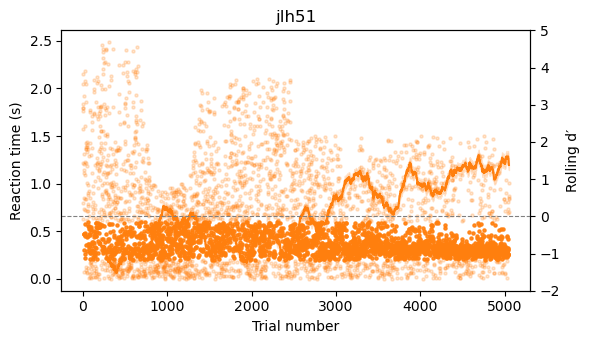

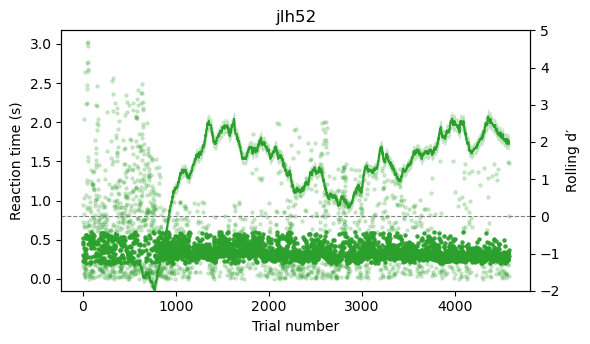

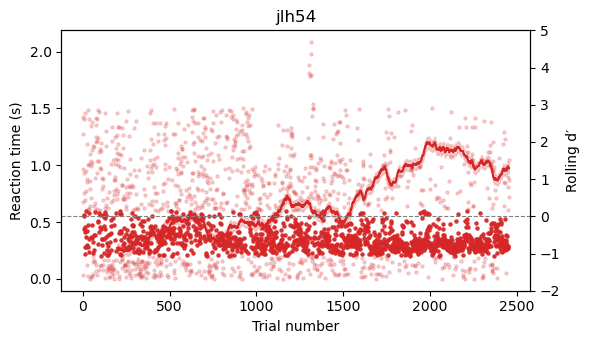

In [53]:
mask = c104_dfx['reaction_time'].between(0, 3)
c104_dfx = c104_dfx[mask]
dfs = [c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]

for df in dfs:
    # mask for rt between 0.2 and 0.6 s
    rt_mask = df['reaction_time'].between(0.2, 0.6)
    
    # true hits: rewarded trials with rt in window
    df['true_success'] = df['rewarded'] & rt_mask
    
    # true false-positives: catch_false_alarm trials with rt in window
    df['true_FP'] = df['catch_false_alarm'] & rt_mask

colors = plt.get_cmap('tab10').colors[:5]
window_size = 200 

for i, og_df in enumerate([c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]):
    fig = plt.figure(figsize=(6, 3.54))
    ax_rt = fig.add_subplot(111)
    ax_dp = ax_rt.twinx()
    color = colors[i]
    df = (
        og_df[(~og_df['catch']) & (og_df['rewarded']) & (og_df['grating_contrast_int'] > 30)]
        .reset_index(drop=True)
        .copy()
            )
    # scatter RTs
    ts = df[df['true_success']]
    fo = df[~df['true_success']]
    ax_rt.scatter(ts.index, ts['reaction_time'], s=5, alpha=0.9, color=color, label='True Positive')
    ax_rt.scatter(fo.index, fo['reaction_time'], s=5, alpha=0.2, color=color, label='False Positive')
    ax_rt.set_xlabel('Trial number')
    ax_rt.set_ylabel('Reaction time (s)')
    #ax_rt.set_title(df.mouseid.unique()[0])
    
    # compute rolling hit & FA counts
    hits = df['true_success'].rolling(window_size).sum()
    fas  = (~df['true_success']).rolling(window_size).sum()
    hr   = hits / window_size
    fa   = fas  / window_size
    
    # clip & compute rolling d′
    hr_clipped = np.clip(hr, 1e-5, 1 - 1e-5)
    fa_clipped = np.clip(fa, 1e-5, 1 - 1e-5)
    dp = norm.ppf(hr_clipped) - norm.ppf(fa_clipped)
    
    # estimate SE(dp) via error‐propagation:
    z_hr    = norm.ppf(hr_clipped)
    z_fa    = norm.ppf(fa_clipped)
    pdf_hr  = norm.pdf(z_hr)
    pdf_fa  = norm.pdf(z_fa)
    var_zhr = hr_clipped * (1-hr_clipped) / (window_size * pdf_hr**2)
    var_zfa = fa_clipped * (1-fa_clipped) / (window_size * pdf_fa**2)
    se_dp   = np.sqrt(var_zhr + var_zfa)
    
    # overlay rolling d′ + cloud
    ax_dp.plot(np.arange(0, len(dp)), dp, '-', color=color, linewidth=1.5, label=f'Rolling d′ ({window_size})')
    ax_dp.fill_between(np.arange(0, len(dp)), dp - se_dp, dp + se_dp, color=color, alpha=0.2)
    ax_dp.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax_dp.set_ylabel("Rolling d′")
    ax_dp.set_ylim(-2, 5)
    
    # legends
    #ax_rt.legend(loc='upper left', markerscale=2, fontsize='small')
    #ax_dp.legend(loc='upper right', fontsize='small')
    plt.title(og_df['mouseid'].unique()[0])
    plt.tight_layout()


avg trials (filtered) to sustained d' (~>-0.3): 1353.8 ± 496.8 (n=4)
avg trials (continuous numbering) to sustained d' (~>-0.3): 14801.8 ± 5154.3 (n=4)
per mouse (filtered, continuous):
  c104: 656, 5655
  jlh51: 2824, 27257
  jlh52: 880, 7043
  jlh54: 1055, 19252


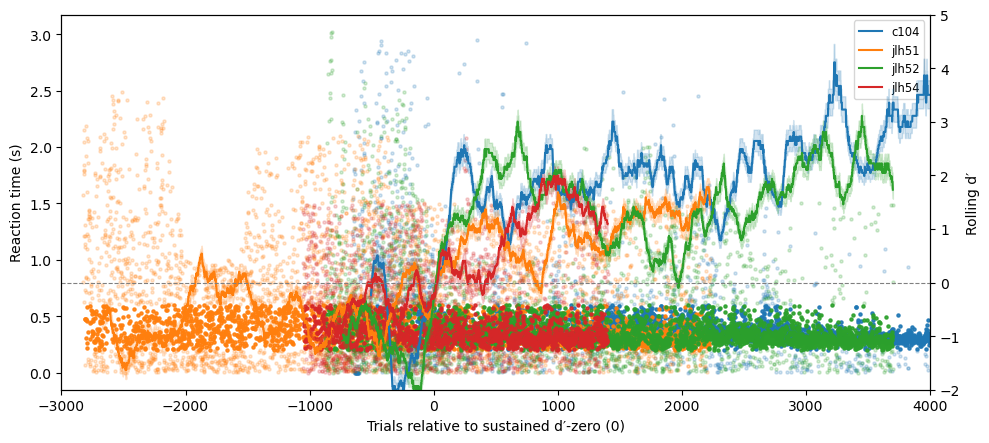

In [ ]:
# add this import if not already present
from scipy.stats import sem

colors = plt.get_cmap('tab10').colors[:6]
window_size = 150

fig = plt.figure(figsize=(10, 4.54))
ax_rt = fig.add_subplot(111)
ax_dp = ax_rt.twinx()

learned_idx_dict = {}

# collect per-mouse counts
trials_to_sustain = []          # trials from filtered df start (inclusive)
cont_trials_to_sustain = []     # using continuous trial numbering (inclusive)
per_mouse_counts = {}

for i, og_df in enumerate([c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]):
    color = colors[i]
    df = (
        og_df[(~og_df['catch']) & (og_df['rewarded']) & (og_df['grating_contrast_int'] > 30)]
        .reset_index(drop=True)
        .copy()
    )
    
    # 1) compute rolling d′
    hits = df['true_success'].rolling(window_size).sum()
    fas  = (~df['true_success']).rolling(window_size).sum()
    hr   = hits / window_size
    fa   = fas  / window_size
    hr_c = np.clip(hr,  1e-5, 1-1e-5)
    fa_c = np.clip(fa,  1e-5, 1-1e-5)
    dp   = norm.ppf(hr_c) - norm.ppf(fa_c)
    
    # error-prop se(dp)
    zhr   = norm.ppf(hr_c);   zfa   = norm.ppf(fa_c)
    pdfhr = norm.pdf(zhr);    pdffa = norm.pdf(zfa)
    varhr = hr_c*(1-hr_c)/(window_size*pdfhr**2)
    varfa = fa_c*(1-fa_c)/(window_size*pdffa**2)
    se_dp = np.sqrt(varhr + varfa)
    
    # 2) find first index that sustains ~zero (using -0.3 threshold, as in your code)
    valid_ix = np.where(~np.isnan(dp))[0]
    sustained_idx = None
    for idx in valid_ix:
        if np.all(dp[idx:] > -0.3):
            sustained_idx = idx
            break
    if sustained_idx is None:
        sustained_idx = len(dp) - 1  # never sustains: align the end
    
    learned_trial = df[df.index == sustained_idx].cont_trial_number.values[0].astype(int)
    learned_idx_dict[og_df['mouseid'].unique()[0]] = learned_trial

    # --- counts to reach sustained point ---
    n_trials = sustained_idx + 1  # inclusive
    cont_start = int(df['cont_trial_number'].iloc[0])
    cont_n = int(learned_trial - cont_start + 1)  # inclusive

    trials_to_sustain.append(n_trials)
    cont_trials_to_sustain.append(cont_n)
    per_mouse_counts[df.mouseid.unique()[0]] = {'filtered_trials': n_trials, 'cont_trials': cont_n}
    # --------------------------------------

    # 3) shifted x
    x_orig    = np.arange(len(df))
    x_shifted = x_orig - sustained_idx
    
    # 4) scatter RT
    tp = df[df['true_success']]
    fp = df[~df['true_success']]
    ax_rt.scatter(tp.index - sustained_idx, tp['reaction_time'], s=5, alpha=0.9, color=color)
    ax_rt.scatter(fp.index - sustained_idx, fp['reaction_time'], s=5, alpha=0.2, color=color)
    
    # 5) plot shifted d′ + cloud
    mask = ~np.isnan(dp)
    ax_dp.plot(x_shifted[mask], dp[mask], '-', color=color, linewidth=1.5, label=f"{df.mouseid.unique()[0]}")
    ax_dp.fill_between(x_shifted[mask], dp[mask] - se_dp[mask], dp[mask] + se_dp[mask], color=color, alpha=0.2)

# finalize plot
ax_rt.set_xlabel("Trials relative to sustained d′-zero (0)")
ax_rt.set_ylabel("Reaction time (s)")
ax_dp.set_ylabel("Rolling d′")
ax_dp.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax_dp.set_ylim(-2, 5)
ax_rt.set_xlim(-3000, 4000)
h_rt, l_rt = ax_rt.get_legend_handles_labels()
h_dp, l_dp = ax_dp.get_legend_handles_labels()
ax_rt.legend(h_dp, l_dp, loc='upper right', markerscale=2, fontsize='small')
plt.tight_layout()
#plt.savefig(os.path.join(save_path, "rolling_dprime_sustained.png"))
#plt.savefig(os.path.join(save_path, "rolling_dprime_sustained.pdf"))

# --- print averages ---
mean_n   = float(np.mean(trials_to_sustain))
sem_n    = float(sem(trials_to_sustain)) if len(trials_to_sustain) > 1 else float('nan')
mean_cn  = float(np.mean(cont_trials_to_sustain))
sem_cn   = float(sem(cont_trials_to_sustain)) if len(cont_trials_to_sustain) > 1 else float('nan')

print(f"avg trials (filtered) to sustained d' (~>-0.3): {mean_n:.1f} ± {sem_n:.1f} (n={len(trials_to_sustain)})")
print(f"avg trials (continuous numbering) to sustained d' (~>-0.3): {mean_cn:.1f} ± {sem_cn:.1f} (n={len(cont_trials_to_sustain)})")
print("per mouse (filtered, continuous):")
for m, v in per_mouse_counts.items():
    print(f"  {m}: {v['filtered_trials']}, {v['cont_trials']}")


# generalization to moving circle

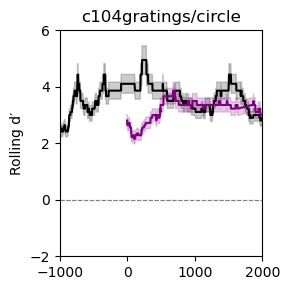

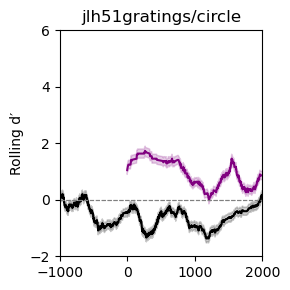

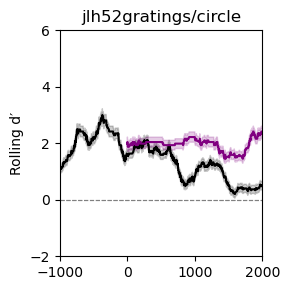

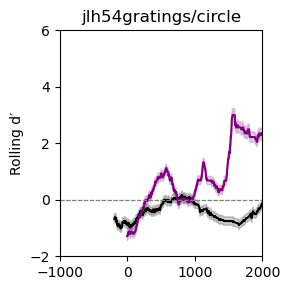

In [25]:
color = colors[i]
window_size = 150

for og_df in [c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]:
    fig = plt.figure(figsize=(3, 3))
    ax_dp = fig.add_subplot(111)
    for task in ['grating_contrast_int', 'circle_contrast_int']:
        if task == 'grating_contrast_int':
            color = 'black'
        else:
            color = 'purple'
        df = (
            og_df[(~og_df['catch']) & (og_df['rewarded'])]
                    .reset_index(drop=True)
                    .copy()
                        )
        zero_idx = df[df['circle_contrast_int'] > 30].index[window_size]
        df = df[df[task] > 30]
        
        
        # scatter RTs
        ts = df[df['true_success']]
        fo = df[~df['true_success']]

        # compute rolling hit & FA counts
        hits = df['true_success'].rolling(window_size).sum()
        fas  = (~df['true_success']).rolling(window_size).sum()
        hr   = hits / window_size
        fa   = fas  / window_size

        # clip & compute rolling d′
        hr_clipped = np.clip(hr, 1e-5, 1 - 1e-5)
        fa_clipped = np.clip(fa, 1e-5, 1 - 1e-5)
        dp = norm.ppf(hr_clipped) - norm.ppf(fa_clipped)

        # estimate SE(dp) via error‐propagation:
        z_hr    = norm.ppf(hr_clipped)
        z_fa    = norm.ppf(fa_clipped)
        pdf_hr  = norm.pdf(z_hr)
        pdf_fa  = norm.pdf(z_fa)
        var_zhr = hr_clipped * (1-hr_clipped) / (window_size * pdf_hr**2)
        var_zfa = fa_clipped * (1-fa_clipped) / (window_size * pdf_fa**2)
        se_dp   = np.sqrt(var_zhr + var_zfa)

        # overlay rolling d′ + cloud
        
        ax_dp.plot((df.index)-zero_idx, dp, '-', color=color, linewidth=1.5, label=f'Rolling d′ ({window_size})')
        ax_dp.fill_between((df.index)-zero_idx, dp - se_dp, dp + se_dp, color=color, alpha=0.2)
        ax_dp.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax_dp.set_ylabel("Rolling d′")
        ax_dp.set_ylim(-2, 6)
        ax_dp.set_yticks([-2, 0, 2, 4, 6])

    
    plt.xlim([-1000, 2000])
    plt.title(f'{df.mouseid.unique()[0]}gratings/circle')
    plt.tight_layout()
    #plt.savefig(os.path.join(save_path, f"{df.mouseid.unique()[0]}_rolling_dprime_gratings_circle_lineonly.png"))
    #plt.savefig(os.path.join(save_path, f"{df.mouseid.unique()[0]}_rolling_dprime_gratings_circle_lineonly.pdf"))

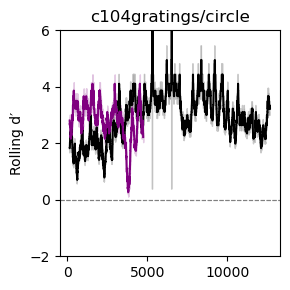

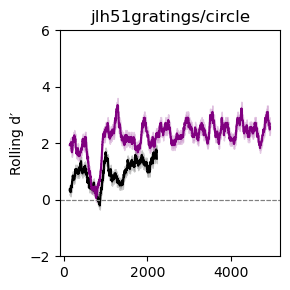

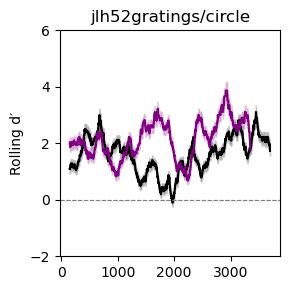

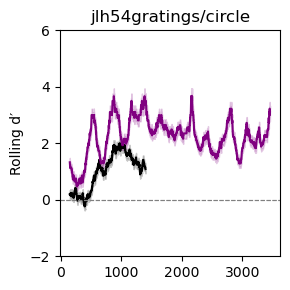

In [66]:
color = colors[i]
window_size = 150

for og_df in [c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]:
    mouseid = og_df['mouseid'].unique()[0]
    learned_point = learned_idx_dict[mouseid] 
    fig = plt.figure(figsize=(3, 3))
    ax_dp = fig.add_subplot(111)
    for task in ['grating_contrast_int', 'circle_contrast_int']:
        if task == 'grating_contrast_int':
            color = 'black'
        else:
            color = 'purple'
        df = (
            og_df[(~og_df['catch']) & (og_df['rewarded'])]
                    .reset_index(drop=True)
                    .copy()
                        )
        zero_idx = df[df['circle_contrast_int'] > 30].index[window_size]
        df = df[df[task] > 30]
        df = df[df['cont_trial_number'] >= learned_point].reset_index(drop = True)
        
        # scatter RTs
        ts = df[df['true_success']]
        fo = df[~df['true_success']]

        # compute rolling hit & FA counts
        hits = df['true_success'].rolling(window_size).sum()
        fas  = (~df['true_success']).rolling(window_size).sum()
        hr   = hits / window_size
        fa   = fas  / window_size

        # clip & compute rolling d′
        hr_clipped = np.clip(hr, 1e-5, 1 - 1e-5)
        fa_clipped = np.clip(fa, 1e-5, 1 - 1e-5)
        dp = norm.ppf(hr_clipped) - norm.ppf(fa_clipped)

        # estimate SE(dp) via error‐propagation:
        z_hr    = norm.ppf(hr_clipped)
        z_fa    = norm.ppf(fa_clipped)
        pdf_hr  = norm.pdf(z_hr)
        pdf_fa  = norm.pdf(z_fa)
        var_zhr = hr_clipped * (1-hr_clipped) / (window_size * pdf_hr**2)
        var_zfa = fa_clipped * (1-fa_clipped) / (window_size * pdf_fa**2)
        se_dp   = np.sqrt(var_zhr + var_zfa)

        # overlay rolling d′ + cloud
        
        ax_dp.plot((df.index), dp, '-', color=color, linewidth=1.5, label=f'Rolling d′ ({window_size})')
        ax_dp.fill_between((df.index), dp - se_dp, dp + se_dp, color=color, alpha=0.2)
        ax_dp.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax_dp.set_ylabel("Rolling d′")
        ax_dp.set_ylim(-2, 6)
        ax_dp.set_yticks([-2, 0, 2, 4, 6])

        idx = (df['cont_trial_number'] - learned_point).abs().idxmin()
           
    plt.title(f'{df.mouseid.unique()[0]}gratings/circle')
    plt.tight_layout()
    #plt.savefig(os.path.join(save_path, f"{df.mouseid.unique()[0]}_rolling_dprime_gratings_circle_lineonly.png"))
    #plt.savefig(os.path.join(save_path, f"{df.mouseid.unique()[0]}_rolling_dprime_gratings_circle_lineonly.pdf"))

One-sample t-tests vs 0:
grating_contrast_int: mean=1.623, std = 0.915, n=4, t=3.548, p=0.0381
circle_contrast_int: mean=2.354, std = 0.300, n=4, t=15.675, p=0.000564


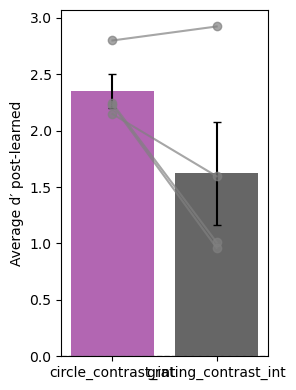

In [541]:
from scipy.stats import ttest_1samp

window_size = 150
results = []

for og_df in [c104_dfx, jlh51_dfx, jlh52_dfx, jlh54_dfx]:
    mouseid = og_df['mouseid'].unique()[0]
    learned_point = learned_idx_dict[mouseid] 

    for task in ['grating_contrast_int', 'circle_contrast_int']:
        df = (
            og_df[(~og_df['catch']) & (og_df['rewarded'])]
            .reset_index(drop=True)
            .copy()
        )

        df = df[df[task] > 30]
        df = df[df['cont_trial_number'] >= learned_point].reset_index(drop=True)

        # rolling counts
        hits = df['true_success'].rolling(window_size).sum()
        fas  = (~df['true_success']).rolling(window_size).sum()
        hr   = hits / window_size
        fa   = fas / window_size

        # clip & compute rolling d′
        hr_clipped = np.clip(hr, 1e-5, 1 - 1e-5)
        fa_clipped = np.clip(fa, 1e-5, 1 - 1e-5)
        dp = norm.ppf(hr_clipped) - norm.ppf(fa_clipped)

        # average d′ after learned_point
        mean_dp = np.nanmean(dp)
        results.append({'mouseid': mouseid, 'task': task, 'dp': mean_dp})

# --- make dataframe ---
res_df = pd.DataFrame(results)

# pivot wide for paired plotting
dp_wide = res_df.pivot(index='mouseid', columns='task', values='dp')

# --- bar plot with paired points ---
fig, ax = plt.subplots(figsize=(3,4))

means = res_df.groupby('task')['dp'].mean()
sems  = res_df.groupby('task')['dp'].sem()

# bars
ax.bar(means.index, means.values, yerr=sems.values, 
       color=['purple','black'], alpha=0.6, capsize=3)

# paired datapoints
for mouseid, row in dp_wide.iterrows():
    ax.plot(row.index, row.values, 'o-', color='gray', alpha=0.7)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel("Average d′ post-learned")

plt.tight_layout()
save_path = 'C:\\Users\\jordan\\Documents\\combined_figs\\behavior\\learning'
#plt.savefig(os.path.join(save_path, 'generalization_bar.pdf'))
#plt.savefig(os.path.join(save_path, 'generalization_bar.png'))
# --- statistical testing against 0 ---
print("One-sample t-tests vs 0:")
for task in res_df['task'].unique():
    vals = res_df[res_df['task']==task]['dp']
    tstat, pval = ttest_1samp(vals, 0, nan_policy='omit')
    print(f"{task}: mean={vals.mean():.3f}, std = {vals.std():.3f}, n={len(vals)}, t={tstat:.3f}, p={pval:.3g}")



In [538]:
from scipy.stats import ttest_rel, ttest_1samp

print("One-sample t-tests vs 0:")
for task in res_df['task'].unique():
    vals = res_df[res_df['task'] == task]['dp']
    tstat, pval = ttest_1samp(vals, 0, nan_policy='omit')
    print(f"{task}: mean={vals.mean():.3f}, std={vals.std(ddof=1):.3f}, n={len(vals)}, "
          f"t={tstat:.3f}, p={pval:.3g}")

# --- paired comparison: grating vs circle ---
grating_vals = dp_wide['grating_contrast_int']
circle_vals  = dp_wide['circle_contrast_int']

tstat_pair, pval_pair = ttest_rel(grating_vals, circle_vals, nan_policy='omit')
mean_diff = (grating_vals - circle_vals).mean()
std_diff  = (grating_vals - circle_vals).std(ddof=1)

print("\nPaired t-test: Gratings vs Circles")
print(f"mean grating={grating_vals.mean():.3f}, std={grating_vals.std(ddof=1):.3f}")
print(f"mean circle ={circle_vals.mean():.3f}, std={circle_vals.std(ddof=1):.3f}")
print(f"mean diff   ={mean_diff:.3f}, std diff={std_diff:.3f}, n={len(grating_vals)}")
print(f"t={tstat_pair:.3f}, p={pval_pair:.3g}")


One-sample t-tests vs 0:
grating_contrast_int: mean=1.623, std=0.915, n=4, t=3.548, p=0.0381
circle_contrast_int: mean=2.354, std=0.300, n=4, t=15.675, p=0.000564

Paired t-test: Gratings vs Circles
mean grating=1.623, std=0.915
mean circle =2.354, std=0.300
mean diff   =-0.731, std diff=0.658, n=4
t=-2.223, p=0.113


# detection of all stimuli in learned mice

In [73]:
save_base = r"C:\Users\jordan\Desktop\detection\analysis"
Lc104_df = pd.read_csv(os.path.join(save_base, "c104_df.csv"))
Ljlh52_df = pd.read_csv(os.path.join(save_base, "jlh52_df.csv"))
Ljlh51_df = pd.read_csv(os.path.join(save_base, "jlh51_df.csv"))
Ljlh54_df = pd.read_csv(os.path.join(save_base, "jlh54_df.csv"))

Lcombined_df = pd.read_csv(os.path.join(save_base, "combined_df.csv"))

C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\465583951.py:2: DtypeWarning: Columns (20,21,23,25,26,33,34,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  Lc104_df = pd.read_csv(os.path.join(save_base, "c104_df.csv"))
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\465583951.py:3: DtypeWarning: Columns (31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  Ljlh52_df = pd.read_csv(os.path.join(save_base, "jlh52_df.csv"))
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\465583951.py:4: DtypeWarning: Columns (31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  Ljlh51_df = pd.read_csv(os.path.join(save_base, "jlh51_df.csv"))
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\465583951.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  Ljlh54_df = pd.read_csv(os.path.join(save_base, "jlh54_df.csv"))
C:\Users\jordan\AppData\Loc

## useful functions

In [495]:
import seaborn as sns
def calculate_raw_lapse_rate(df, window_size=10):
    """
    Calculate raw lapse rate including false alarms and filter trials based on a threshold.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - window_size (int): Size of the rolling window for lapse rate calculation.

    Returns:
    - pd.DataFrame: Filtered dataframe with lapse rate added.
    """
    # Calculate rolling lapse rate
    df['rolling_lapse_rate'] = df['lapse'].rolling(window=window_size, min_periods=1).mean()

    # Filter out trials with rolling lapse rate > 70%
    filtered_df = df[df['rolling_lapse_rate'] <= 0.7].copy()

    return filtered_df

def calculate_rolling_false_alarm_rate(df, window_size=10):
    """
    Calculate rolling false alarm rate and filter trials based on a threshold.
    """
    df['rolling_false_alarm_rate'] = df['false_alarm'].rolling(window=window_size, min_periods=1).mean()
    filtered_df = df[df['rolling_false_alarm_rate'] <= 0.7].copy()
    return filtered_df

## filtering (getting rid of periods of poor engagement or excessive licking)

In [ ]:
# Apply the function to all dataframes
c104_df_filtered = calculate_raw_lapse_rate(Lc104_df, window_size=10)
jlh52_df_filtered = calculate_raw_lapse_rate(Ljlh52_df, window_size=10)
jlh51_df_filtered = calculate_raw_lapse_rate(Ljlh51_df, window_size=10)
jlh54_df_filtered = calculate_raw_lapse_rate(Ljlh54_df, window_size=10)

combined_df_filtered = pd.concat([c104_df_filtered, jlh52_df_filtered, jlh51_df_filtered, jlh54_df_filtered], ignore_index=True)

# Apply filtering
c104_df_filtered_fa = calculate_rolling_false_alarm_rate(Lc104_df, window_size=10)
jlh52_df_filtered_fa = calculate_rolling_false_alarm_rate(Ljlh52_df, window_size=10)
jlh51_df_filtered_fa = calculate_rolling_false_alarm_rate(Ljlh51_df, window_size=10)
jlh54_df_filtered_fa = calculate_rolling_false_alarm_rate(Ljlh54_df, window_size=10)

c104_df_filtered_combined = calculate_raw_lapse_rate(c104_df_filtered_fa, window_size=10)
jlh52_df_filtered_combined = calculate_raw_lapse_rate(jlh52_df_filtered_fa, window_size=10)
jlh51_df_filtered_combined = calculate_raw_lapse_rate(jlh51_df_filtered_fa, window_size=10)
jlh54_df_filtered_combined = calculate_raw_lapse_rate(jlh54_df_filtered_fa, window_size=10)

# Combine filtered dataframes for plotting
combined_df_fa = pd.concat([c104_df_filtered_fa, jlh52_df_filtered_fa, jlh51_df_filtered_fa, jlh54_df_filtered_fa], ignore_index=True)
combined_df_combined = pd.concat([c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined], ignore_index=True)

combined_df_combined = combined_df_combined[combined_df_combined['include'] != 'no']

In [92]:
pd.set_option('display.max_columns', None)

## detection psychometric curves for estim and visual stim

C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\3963379920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estim_df['estim_amp_abs'] = estim_df['estim_amp_abs'] = estim_df['estim_amp_int'].abs()
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\3963379920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estim_df['estim_amp_abs'] = estim_df['estim_amp_abs'] = estim_df['estim_amp_int'].abs()
C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\3963379920.py:12: SettingWithCopyWarning: 
A value is t

[5, 25, 50, 100]


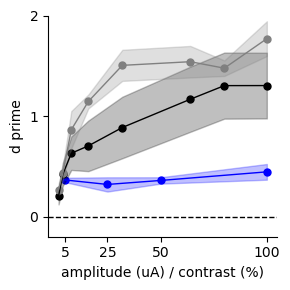

In [ ]:
# estim with visual overlaid
mice = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined]

fig, ax = plt.subplots(figsize = (3,3))

#dprime_amp_dict = {-100: [], -50:[], -25:[], -5:[],5: [], 25:[], 50:[], 100:[]}
dprime_amp_dict = {5: [], 25:[], 50:[], 100:[]}
for mouse_df in mice:
    df = mouse_df.copy()

    estim_df = df[(df['estim_trial']) &
                    (df['estim_amp_int'] != 0) & (df['n_pulses'] == 1)]
    estim_df['estim_amp_abs'] = estim_df['estim_amp_abs'] = estim_df['estim_amp_int'].abs()
    
    # bc dfs are kinda jank only select for conditions i care about rewarded, lapse, catch_false_alarm, and catch_lapse 
    estim_df = estim_df[(estim_df['rewarded'] == True) |
             (estim_df['lapse'] == True) |
             (estim_df['catch_false_alarm']) == True |
             (estim_df['catch_lapse'] == True)          
            ]
    #print(estim_df.estim_amp_int.unique())
    catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
    #for amp in np.sort(estim_df.estim_amp_int.unique()):
    for amp in np.sort(estim_df.estim_amp_abs.unique()):
        amp = int(amp)
        #d = estim_df[estim_df['estim_amp_int'] == amp]
        d = estim_df[estim_df['estim_amp_abs'] == amp]
        hit_rate = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        dprime = norm.ppf(hit_rate) - norm.ppf(catch_rate)
        #ax.scatter(amp, dprime, s = 5, color = 'lightblue')
        dprime_amp_dict[amp].append(dprime)

means = []
sems = []
amps = []

for amp, dprime_list in dprime_amp_dict.items():
    #print(amp)
    if int(amp) == -100:
        print(dprime_list)
        dprime_list = dprime_list[:3]
    mean_dprime = np.mean(dprime_list)
    sem_dprime = sem(dprime_list)
    means.append(mean_dprime)
    sems.append(sem_dprime)
    amps.append(amp)
    #ax.scatter(amp, mean_dprime, color = 'blue', s = 40)
    #ax.errorbar(amp, mean_dprime, yerr = sem_dprime, color = 'blue')
print(amps)
amps  = np.asarray(amps, dtype=float)
means = np.asarray(means, dtype=float)
sems  = np.asarray(sems, dtype=float)

ax.scatter(amps, means, s = 25, c = 'blue')
ax.plot(amps, means, color = 'blue', lw = 1)
ax.fill_between(amps, means - sems, means + sems, color = 'blue', alpha = 0.25)

dprime_gratings_dict = {2: [], 4:[], 8:[], 16:[], 32: [], 64:[], 80:[], 100:[]}
for mouse_df in mice:
    df = mouse_df.copy()
    gratings_df = df[(df['grating_trial']) &
                    (df['grating_contrast_int'] != 0)]
    
    gratings_df = gratings_df[(gratings_df['rewarded'] == True) |
            (gratings_df['lapse'] == True) |
            (gratings_df['catch_false_alarm']) == True |
            (gratings_df['catch_lapse'] == True)          
        ]

    #print(gratings_df.grating_contrast_int.unique())
    for con in gratings_df.grating_contrast_int.unique():
        con = int(con)
        d = gratings_df[gratings_df['grating_contrast_int'] == con]
        hit_rate = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
        dprime = norm.ppf(hit_rate) - norm.ppf(catch_rate)
        #ax.scatter(con, dprime, s = 5, color = 'darkgray')
        dprime_gratings_dict[con].append(dprime)

grat_means = []
grat_sems = []
grat_cons = []
for con, dprime_list in dprime_gratings_dict.items():
    mean_dprime = np.mean(dprime_list)
    sem_dprime = sem(dprime_list)
    #ax.scatter(con, mean_dprime, color = 'black', s = 40)
    #ax.errorbar(con, mean_dprime, yerr = sem_dprime, color = 'black')    
    grat_means.append(mean_dprime)
    grat_sems.append(sem_dprime) 
    grat_cons.append(int(con))

grat_means = np.array(grat_means) 
grat_sems = np.array(grat_sems) 
grat_cons = np.array(grat_cons) 
ax.scatter(grat_cons, grat_means, s = 25, c = 'k')
ax.plot(grat_cons, grat_means, color = 'k', lw = 1)
ax.fill_between(grat_cons, grat_means - grat_sems, grat_means + grat_sems, color = 'k', alpha = 0.25)
    
    
dprime_circ_dict = {2: [], 4:[], 8:[], 16:[], 32: [], 64:[], 80:[], 100:[]}
for mouse_df in mice:
    df = mouse_df.copy()
    circ_df = df[(df['moving_circle_trial']) &
                    (df['circle_contrast_int'] != 0)]
    
    circ_df = circ_df[(circ_df['rewarded'] == True) |
            (circ_df['lapse'] == True) |
            (circ_df['catch_false_alarm']) == True |
            (circ_df['catch_lapse'] == True)          
        ]

    #print(circ_df.circle_contrast_int.unique())
    for con in circ_df.circle_contrast_int.unique():
        con = int(con)
        d = circ_df[circ_df['circle_contrast_int'] == con]
        hit_rate = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
        dprime = norm.ppf(hit_rate) - norm.ppf(catch_rate)
        #ax.scatter(con, dprime, s = 5, color = 'purple')
        dprime_circ_dict[con].append(dprime)

circ_means = []
circ_sems = []
circ_cons = []
for con, dprime_list in dprime_circ_dict.items():
    mean_dprime = np.mean(dprime_list)
    sem_dprime = sem(dprime_list)
    circ_means.append(mean_dprime)
    circ_sems.append(sem_dprime) 
    circ_cons.append(int(con))

circ_means = np.array(circ_means) 
circ_sems = np.array(circ_sems) 
circ_cons = np.array(circ_cons) 

ax.scatter(circ_cons, circ_means, s = 25, c = 'gray')
ax.plot(circ_cons, circ_means, color = 'gray', lw = 1)
ax.fill_between(circ_cons, circ_means - circ_sems, circ_means + circ_sems, color = 'gray', alpha = 0.25)

#ax.set_xscale('log')
#ax.set_xticks([-100, -50, -25, -5, 5, 25, 50, 100])
#ax.set_xticklabels([-100, -50, -25, -5, 5, 25, 50, 100], fontsize = 9)
ax.set_xticks([5, 25, 50, 100])
ax.set_xticklabels([5, 25, 50, 100])
ax.set_yticks([0, 1, 2])
ax.set_ylim(-0.2, 2)
ax.axhline(0, linestyle = '--', lw = 1, color = 'k')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('d prime')
ax.set_xlabel('amplitude (uA) / contrast (%)')

plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior\dprime'

#plt.savefig(os.path.join(save_path, 'estim_detection_ABS.png'))
#plt.savefig(os.path.join(save_path, 'estim_detection_ABS.pdf'))

In [530]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

rows = []
for amp, dprime_list in dprime_amp_dict.items():
    for dp in dprime_list:
        rows.append({"Amplitude": float(amp), "Dprime": dp})

anova_df = pd.DataFrame(rows)

# fit linear model
model = smf.ols("Dprime ~ Amplitude", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\n=== ANOVA: Dprime ~ Amplitude ===")
print(anova_table)
print(model.summary())

# descriptive stats
print("\n--- Descriptive stats per amplitude ---")
summary = (
    anova_df.groupby("Amplitude")["Dprime"]
            .agg(n="count", mean="mean", std=lambda x: x.std(ddof=1))
            .round(3)
)
print(summary)

# optional overall summary
overall_mean = np.nanmean(anova_df["Dprime"])
overall_std  = np.nanstd(anova_df["Dprime"], ddof=1)
print(f"\nOverall -> mean={overall_mean:.3f}, std={overall_std:.3f}, n={len(anova_df)}")



=== ANOVA: Dprime ~ Amplitude ===
             sum_sq    df        F    PR(>F)
Amplitude  0.016861   1.0  1.74851  0.208858
Residual   0.125359  13.0      NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                 Dprime   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.749
Date:                Fri, 29 Aug 2025   Prob (F-statistic):              0.209
Time:                        14:11:36   Log-Likelihood:                 14.601
No. Observations:                  15   AIC:                            -25.20
Df Residuals:                      13   BIC:                            -23.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err        

c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


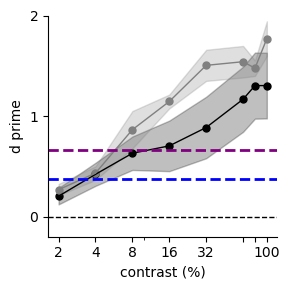

In [ ]:
# visual with estim lines

fig, ax = plt.subplots(figsize = (3,3))
dprime_gratings_dict = {2: [], 4:[], 8:[], 16:[], 32: [], 64:[], 80:[], 100:[]}
for mouse_df in mice:
    df = mouse_df.copy()
    gratings_df = df[(df['grating_trial']) &
                    (df['grating_contrast_int'] != 0)]
    
    gratings_df = gratings_df[(gratings_df['rewarded'] == True) |
            (gratings_df['lapse'] == True) |
            (gratings_df['catch_false_alarm']) == True |
            (gratings_df['catch_lapse'] == True)          
        ]

    #print(gratings_df.grating_contrast_int.unique())
    for con in gratings_df.grating_contrast_int.unique():
        con = int(con)
        d = gratings_df[gratings_df['grating_contrast_int'] == con]
        hit_rate = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
        dprime = norm.ppf(hit_rate) - norm.ppf(catch_rate)
        #ax.scatter(con, dprime, s = 5, color = 'darkgray')
        dprime_gratings_dict[con].append(dprime)

grat_means = []
grat_sems = []
grat_cons = []
for con, dprime_list in dprime_gratings_dict.items():
    mean_dprime = np.mean(dprime_list)
    sem_dprime = sem(dprime_list)
    #ax.scatter(con, mean_dprime, color = 'black', s = 40)
    #ax.errorbar(con, mean_dprime, yerr = sem_dprime, color = 'black')    
    grat_means.append(mean_dprime)
    grat_sems.append(sem_dprime) 
    grat_cons.append(int(con))

grat_means = np.array(grat_means) 
grat_sems = np.array(grat_sems) 
grat_cons = np.array(grat_cons) 
ax.scatter(grat_cons, grat_means, s = 25, c = 'k')
ax.plot(grat_cons, grat_means, color = 'k', lw = 1)
ax.fill_between(grat_cons, grat_means - grat_sems, grat_means + grat_sems, color = 'k', alpha = 0.25)
    
    
dprime_circ_dict = {2: [], 4:[], 8:[], 16:[], 32: [], 64:[], 80:[], 100:[]}
for mouse_df in mice:
    df = mouse_df.copy()
    circ_df = df[(df['moving_circle_trial']) &
                    (df['circle_contrast_int'] != 0)]
    
    circ_df = circ_df[(circ_df['rewarded'] == True) |
            (circ_df['lapse'] == True) |
            (circ_df['catch_false_alarm']) == True |
            (circ_df['catch_lapse'] == True)          
        ]

    #print(circ_df.circle_contrast_int.unique())
    for con in circ_df.circle_contrast_int.unique():
        con = int(con)
        d = circ_df[circ_df['circle_contrast_int'] == con]
        hit_rate = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
        dprime = norm.ppf(hit_rate) - norm.ppf(catch_rate)
        #ax.scatter(con, dprime, s = 5, color = 'purple')
        dprime_circ_dict[con].append(dprime)

circ_means = []
circ_sems = []
circ_cons = []
for con, dprime_list in dprime_circ_dict.items():
    mean_dprime = np.mean(dprime_list)
    sem_dprime = sem(dprime_list)
    circ_means.append(mean_dprime)
    circ_sems.append(sem_dprime) 
    circ_cons.append(int(con))

circ_means = np.array(circ_means) 
circ_sems = np.array(circ_sems) 
circ_cons = np.array(circ_cons) 

ax.scatter(circ_cons, circ_means, s = 25, c = 'gray')
ax.plot(circ_cons, circ_means, color = 'gray', lw = 1)
ax.fill_between(circ_cons, circ_means - circ_sems, circ_means + circ_sems, color = 'gray', alpha = 0.25)

ax.set_xscale('symlog')
ax.set_xticks([2, 4, 8, 16, 32, 64, 80, 100], [2, 4, 8, 16, 32, '', '', 100])
#ax.set_xticks([-100, -50, -25, -5, 5, 25, 50, 100])
ax.set_yticks([0, 1, 2])
ax.set_ylim(-0.2, 2)
ax.axhline(0, linestyle = '--', lw = 1, color = 'k')

ax.axhline(mean_train, linestyle = '--', lw = 2, color = 'purple')
ax.axhline(mean_pulse, linestyle = '--', lw = 2, color = 'blue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('d prime')
ax.set_xlabel('contrast (%)')
plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior\dprime'

plt.savefig(os.path.join(save_path, 'circle_gratings_detection.png'))
plt.savefig(os.path.join(save_path, 'circle_gratings_detection.pdf'))

In [529]:
def run_continuous_anova(dprime_dict, label="Contrast"):
    # build long df
    rows = []
    for contrast, dprime_list in dprime_dict.items():
        for dp in dprime_list:
            rows.append({label: float(contrast), "Dprime": dp})
    df = pd.DataFrame(rows)

    model = smf.ols(f"Dprime ~ {label}", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"\n=== ANOVA for {label} ===")
    print(anova_table)
    print(model.summary())

    print("\n--- Descriptive stats ---")
    summary = (
        df.groupby(label)["Dprime"]
          .agg(n="count", mean="mean", std=lambda x: x.std(ddof=1))
          .round(3)
    )
    print(summary)

    return df, model

circ_df, circ_model = run_continuous_anova(dprime_circ_dict, label="circle")
gratings_df, gratings_model = run_continuous_anova(dprime_gratings_dict, label="gratings")



=== ANOVA for circle ===
            sum_sq    df          F        PR(>F)
circle    6.156414   1.0  46.522931  1.443425e-07
Residual  3.969922  30.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                 Dprime   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     46.52
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.44e-07
Time:                        14:10:54   Log-Likelihood:                -12.014
No. Observations:                  32   AIC:                             28.03
Df Residuals:                      30   BIC:                             30.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

In [542]:
from scipy.stats import ttest_1samp

def run_continuous_anova(dprime_dict, label="Contrast"):
    # build long df
    rows = []
    for contrast, dprime_list in dprime_dict.items():
        for dp in dprime_list:
            rows.append({label: float(contrast), "Dprime": dp})
    df = pd.DataFrame(rows)

    # linear model
    model = smf.ols(f"Dprime ~ {label}", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"\n=== ANOVA for {label} ===")
    print(anova_table)
    print(model.summary())

    print("\n--- Descriptive stats ---")
    summary = (
        df.groupby(label)["Dprime"]
          .agg(n="count", mean="mean", std=lambda x: x.std(ddof=1))
          .round(3)
    )
    print(summary)

    # --- one-sample t-tests at 2% and 4% vs 0 ---
    for c in [2, 4]:
        if c in df[label].unique():
            vals = df.loc[df[label] == c, "Dprime"].dropna()
            if len(vals) > 0:
                tstat, pval = ttest_1samp(vals, 0, nan_policy="omit")
                print(f"\n{label} {c}% vs 0: mean={vals.mean():.3f}, "
                      f"std={vals.std(ddof=1):.3f}, n={len(vals)}, "
                      f"t={tstat:.3f}, p={pval:.3g}")
            else:
                print(f"\n{label} {c}%: no data available")

    return df, model

# run as before
circ_df, circ_model = run_continuous_anova(dprime_circ_dict, label="circle")
gratings_df, gratings_model = run_continuous_anova(dprime_gratings_dict, label="gratings")



=== ANOVA for circle ===
            sum_sq    df          F        PR(>F)
circle    6.156414   1.0  46.522931  1.443425e-07
Residual  3.969922  30.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                 Dprime   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     46.52
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.44e-07
Time:                        18:19:28   Log-Likelihood:                -12.014
No. Observations:                  32   AIC:                             28.03
Df Residuals:                      30   BIC:                             30.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

## pulse vs trains dprimes

mean train: 0.6575455243267927
mean pulse: 0.3708982839657239


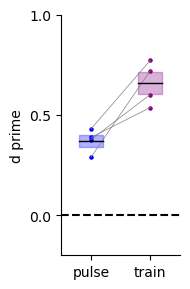

In [ ]:
# pulse vs trains
from scipy.stats import sem 

mice = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined]

fig, ax = plt.subplots(figsize = (2,3))

pulse_ds = [] 
trains_ds = []
for mouse_df in mice:
    df = mouse_df.copy()
    
    df = df[(df['rewarded'] == True) |
             (df['lapse'] == True) |
             (df['catch_false_alarm']) == True |
             (df['catch_lapse'] == True)          
            ]
    pulse_df = df[(df['estim_trial']) &
                    (df['estim_amp_int'] != 0) & (df['n_pulses'] == 1)]
    
    train_df = df[(df['estim_trial']) &
                    (df['estim_amp_int'] != 0) & (df['n_pulses'] > 1)]
    
    catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
    
    pulse_hit = pulse_df['rewarded'].sum() / (pulse_df['rewarded'].sum() + pulse_df['lapse'].sum())
    pulse_dprime = norm.ppf(pulse_hit) - norm.ppf(catch_rate)
    
    train_hit = train_df['rewarded'].sum() / (train_df['rewarded'].sum() + train_df['lapse'].sum())
    train_dprime = norm.ppf(train_hit) - norm.ppf(catch_rate)
    
    pulse_ds.append(pulse_dprime)
    trains_ds.append(train_dprime)
    ax.scatter(0.5, pulse_dprime, s = 5, color = 'blue')
    ax.scatter(1.5, train_dprime, s = 5, color = 'purple')
    ax.plot([0.5, 1.5], [pulse_dprime, train_dprime], lw = 0.5, color = 'gray')
    
mean_train = np.mean(trains_ds) 
sem_train = sem(trains_ds)
mean_pulse = np.mean(pulse_ds)    
sem_pulse = sem(pulse_ds)
ax.plot([0.3, 0.7], [mean_pulse, mean_pulse], lw = 1, color = 'k')
ax.plot([1.3, 1.7], [mean_train, mean_train], lw = 1, color = 'k')
print(f'mean train: {mean_train}')
print(f'mean pulse: {mean_pulse}')
      
ax.fill_between([0.3, 0.7], mean_pulse + sem_pulse, mean_pulse - sem_pulse, alpha = 0.3, color = 'blue')
ax.fill_between([1.3, 1.7], mean_train + sem_train, mean_train - sem_train, alpha = 0.3, color = 'purple')
ax.set_xticks([0.5, 1.5], ['pulse', 'train'])
ax.set_xlim(0, 2)
ax.set_ylim(-0.2, 1)
ax.set_yticks([0, 0.5, 1])
ax.axhline(0, linestyle = '--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('d prime')



plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior\dprime'

#plt.savefig(os.path.join(save_path, 'estim_pulses_trains_paired.png'))
#plt.savefig(os.path.join(save_path, 'estim_pulses_trains_paired.pdf'))

In [528]:
from scipy.stats import ttest_1samp, ttest_rel

# --- Pulse vs 0 ---
tstat_pulse, pval_pulse = ttest_1samp(pulse_ds, 0, nan_policy='omit')
mean_pulse = np.nanmean(pulse_ds)
std_pulse  = np.nanstd(pulse_ds, ddof=1)
print(f"Pulse d′ vs 0: t={tstat_pulse:.3f}, p={pval_pulse:.3g}")
print(f"   mean={mean_pulse:.3f}, std={std_pulse:.3f}, n={len(pulse_ds)}")

# --- Train vs 0 ---
tstat_train, pval_train = ttest_1samp(trains_ds, 0, nan_policy='omit')
mean_train = np.nanmean(trains_ds)
std_train  = np.nanstd(trains_ds, ddof=1)
print(f"Train d′ vs 0: t={tstat_train:.3f}, p={pval_train:.3g}")
print(f"   mean={mean_train:.3f}, std={std_train:.3f}, n={len(trains_ds)}")

# --- Paired test: Pulse vs Train ---
tstat_pair, pval_pair = ttest_rel(pulse_ds, trains_ds, nan_policy='omit')
print(f"Pulse vs Train (paired): t={tstat_pair:.3f}, p={pval_pair:.3g}")

Pulse d′ vs 0: t=12.596, p=0.00108
   mean=0.371, std=0.059, n=4
Train d′ vs 0: t=12.188, p=0.00119
   mean=0.658, std=0.108, n=4
Pulse vs Train (paired): t=-4.599, p=0.0193


## cathodal vs anodal leading dprime

C:\Users\jordan\AppData\Local\Temp\ipykernel_32168\2482471987.py:29: RuntimeWarning: invalid value encountered in scalar divide
  an_hit = an_df['rewarded'].sum() / (an_df['rewarded'].sum() + an_df['lapse'].sum())


mean cathodal: 0.33381075025554885
mean anodal: 0.4412880557641817


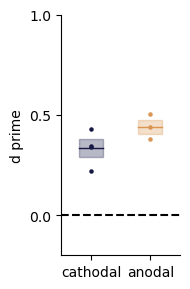

In [ ]:
## cathodal vs anodal leading 
from scipy.stats import sem 
cathodal_color = '#161943'
anodal_color = '#D99551'
mice = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined]

fig, ax = plt.subplots(figsize = (2,3))

cat_ds = [] 
an_ds = []
for mouse_df in mice:
    df = mouse_df.copy()
    
    df = df[(df['rewarded'] == True) |
             (df['lapse'] == True) |
             (df['catch_false_alarm']) == True |
             (df['catch_lapse'] == True)          
            ]
    pulse_df = df[(df['estim_trial']) &
                    (df['estim_amp_int'] != 0) & (df['n_pulses'] == 1)]
    
    cat_df = pulse_df[pulse_df['estim_amp_int'] < 0]
    an_df = pulse_df[pulse_df['estim_amp_int'] > 0]
    
    catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
    
    cat_hit = cat_df['rewarded'].sum() / (cat_df['rewarded'].sum() + cat_df['lapse'].sum())
    cat_dprime = norm.ppf(cat_hit) - norm.ppf(catch_rate)
    
    an_hit = an_df['rewarded'].sum() / (an_df['rewarded'].sum() + an_df['lapse'].sum())
    an_dprime = norm.ppf(an_hit) - norm.ppf(catch_rate)
    
    cat_ds.append(cat_dprime)
    an_ds.append(an_dprime)
    ax.scatter(0.5, cat_dprime, s = 5, color = cathodal_color)
    ax.scatter(1.5, an_dprime, s = 5, color = anodal_color)
    #ax.plot([0.5, 1.5], [cat_dprime, an_dprime], lw = 0.5, color = 'gray')
    
mean_cat = np.nanmean(cat_ds) 
sem_cat = sem(cat_ds)
mean_an = np.nanmean(an_ds)    
sem_an = sem(an_ds[:3])
ax.plot([0.3, 0.7], [mean_cat, mean_cat], lw = 1, color = cathodal_color)
ax.plot([1.3, 1.7], [mean_an, mean_an], lw = 1, color = anodal_color)
print(f'mean cathodal: {mean_cat}')
print(f'mean anodal: {mean_an}')
      
ax.fill_between([0.3, 0.7], mean_cat + sem_cat, mean_cat - sem_cat, alpha = 0.3, color = cathodal_color)
ax.fill_between([1.3, 1.7], mean_an + sem_an, mean_an - sem_an, alpha = 0.3, color = anodal_color)
ax.set_xticks([0.5, 1.5], ['cathodal', 'anodal'])
ax.set_xlim(0, 2)
ax.set_ylim(-0.2, 1)
ax.set_yticks([0, 0.5, 1])
ax.axhline(0, linestyle = '--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('d prime')



plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior\dprime'

plt.savefig(os.path.join(save_path, 'estim_pulses_cathodal_anodal.png'))
plt.savefig(os.path.join(save_path, 'estim_pulses_cathodal_anodal.pdf'))

In [527]:
from scipy.stats import ttest_rel

# --- Paired t-test: cathodal vs anodal ---
tstat_pair, pval_pair = ttest_rel(cat_ds, an_ds, nan_policy='omit')

mean_cat = np.nanmean(cat_ds)
std_cat  = np.nanstd(cat_ds, ddof=1)
mean_an  = np.nanmean(an_ds)
std_an   = np.nanstd(an_ds, ddof=1)

print(f"Cathodal vs Anodal (paired): t={tstat_pair:.3f}, p={pval_pair:.3g}")
print(f"Cathodal -> mean={mean_cat:.3f}, std={std_cat:.3f}, n={len(cat_ds)}")
print(f"Anodal   -> mean={mean_an:.3f}, std={std_an:.3f}, n={len(an_ds)}")


Cathodal vs Anodal (paired): t=-5.852, p=0.028
Cathodal -> mean=0.334, std=0.087, n=4
Anodal   -> mean=0.441, std=0.061, n=4


## different frequencies

100
200
300


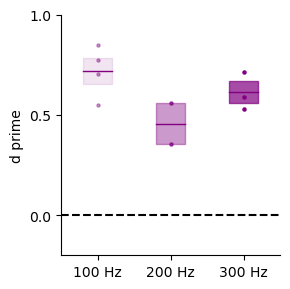

In [510]:
# freqs of trains 

from scipy.stats import sem 

mice = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined]

fig, ax = plt.subplots(figsize = (3,3))


train_dict = {100: [], 200: [], 300: []}
for mouse_df in mice:
    df = mouse_df.copy()
    
    df = df[(df['rewarded'] == True) |
             (df['lapse'] == True) |
             (df['catch_false_alarm']) == True |
             (df['catch_lapse'] == True)          
            ]
    
    train_df = df[(df['estim_trial']) &
                    (df['estim_amp_int'] != 0) & (df['n_pulses'] > 1)]
    
    
    catch_rate = mouse_df['catch_false_alarm'].sum() / (mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())
    
    unique_freqs = train_df.frequency.unique()
    for freq in unique_freqs:
        d = train_df[train_df['frequency'] == freq]
        hit = d['rewarded'].sum() / (d['rewarded'].sum() + d['lapse'].sum())
        dprime = norm.ppf(hit) - norm.ppf(catch_rate)
        train_dict[freq].append(dprime)
        
        if freq == 100:
            x = 0.5
            a = 0.4
        elif freq  == 200:
            x = 1.5
            a = 0.7
        elif freq == 300: 
            x = 2.5 
            a = 1
        ax.scatter(x, dprime, s = 5, color = 'purple', alpha = a)

 
 
for freq, primes in train_dict.items():
    print(freq)
    if freq == 100:
        x = 0.5
        a = 0.4
    elif freq  == 200:
        x = 1.5
        a = 0.7
    elif freq == 300: 
        x = 2.5
        a = 1 
    mean = np.mean(primes) 
    sem_ = sem(primes)
    
    ax.plot([x - 0.2, x + 0.2], [mean, mean], lw = 1, color = 'purple')
    ax.fill_between([x - 0.2, x + 0.2], mean + sem_, mean - sem_, alpha = a - 0.3, color = 'purple')
    

ax.set_xticks([0.5, 1.5, 2.5], ['100 Hz', '200 Hz', '300 Hz'])
ax.set_xlim(0, 3)
ax.set_ylim(-0.2, 1)
ax.set_yticks([0, 0.5, 1])
ax.axhline(0, linestyle = '--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('d prime')

plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior\dprime'
plt.savefig(os.path.join(save_path, 'frequency_dprime.pdf'))
plt.savefig(os.path.join(save_path, 'frequency_dprime.png'))

In [ ]:
from scipy.stats import f_oneway

fstat, pval = f_oneway(train_dict[100], train_dict[200], train_dict[300])
print(f"One-way ANOVA (independent): F={fstat:.3f}, p={pval:.3g}")
# print per-frequency mean, std, n


for freq in [100, 200, 300]:
    arr = np.array(train_dict[freq], dtype=float)
    n = np.sum(~np.isnan(arr))
    mean = np.nanmean(arr) if n > 0 else np.nan
    std  = np.nanstd(arr, ddof=1) if n > 1 else np.nan  # sample std
    print(f"{freq} Hz -> n={n}, mean={mean:.3f}, std={std:.3f}")


One-way ANOVA (independent): F=3.217, p=0.112
100 Hz -> n=4, mean=0.720, std=0.127
200 Hz -> n=2, mean=0.456, std=0.144
300 Hz -> n=3, mean=0.612, std=0.094


## within session trends (habituation?)

c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


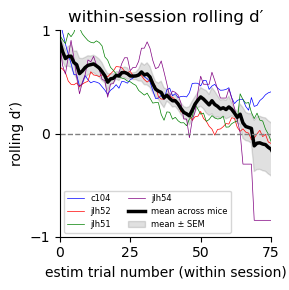

In [494]:
## within session performance across trials (habituation)
window = 15 
mice = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined] #[c104_single_pulse_df, jlh52_single_pulse_df, jlh51_single_pulse_df, jlh54_single_pulse_df]
color_map = {"c104": "blue", "jlh52": "red", "jlh51": "green", "jlh54": "purple"}

per_mouse_mean = {}  # mouseid -> dict(trial_axis, mean, sem)
fig, ax = plt.subplots(figsize = (3,3))

for mouse_df in mice:
    df = mouse_df.copy()
    df = df[(df['estim_trial']) & (df['n_pulses'] == 1)]
    # bc dfs are kinda jenk only select for conditions i care about rewarded, lapse, catch_false_alarm, and catch_lapse 
    df = df[(df['rewarded'] == True) |
             (df['lapse'] == True) |
             (df['catch_false_alarm']) == True |
             (df['catch_lapse'] == True)             
            ]
    #print(df.estim_amp_int.unique())
    session_curves = {}
    
    
    for date, d in df.groupby('date', sort=True):
        d = d.reset_index(drop = True)
        n_trials = (len(d))
        d['trial_number'] = np.arange(n_trials)
        
        # 
        stim_attempt = ((d['estim_amp_int'] != 0) &
                        (d['rewarded'] | d['lapse'])).astype(int)
        catch_attempt = ((d['catch_false_alarm'] | d['catch_lapse'])).astype(int)
        
        stim_hit = ((d['estim_amp_int'] != 0) & d['rewarded']).astype(int)
        catch_fa = (d['catch_false_alarm']).astype(int)

        Hs = roll_sum(stim_hit.values, window)
        Ns = roll_sum(stim_attempt.values, window)
        
        # log-linear correction
        hit_rate = (Hs + 0.5) / (Ns + 1.0)
        fa_rate  = (Hf + 0.5) / (Nf + 1.0) if Nf > 0 else np.full_like(hit_rate, np.nan)
        
        # session-level FA totals to stabilize for noisy low bins
        Hf = float(mouse_df['catch_false_alarm'].sum())
        Nf = float(mouse_df['catch_false_alarm'].sum() + mouse_df['catch_lapse'].sum())

        dprime = norm.ppf(hit_rate) - norm.ppf(fa_rate)        
        session_curves[date] = (d['trial_number'].values, dprime)
        #ax.plot(dprime, color = color, lw = 0.5)
        
    # pad sessions to longest length and average with nans
    max_len = max(len(dp) for (_, dp) in session_curves.values())
    trial_axis = np.arange(max_len)
    
    stacked = []
    for _, (x, dp) in session_curves.items():
        padded = np.full(max_len, np.nan)
        padded[:len(dp)] = dp
        stacked.append(padded)

    stacked = np.vstack(stacked)
    mean_dp = np.nanmean(stacked, axis=0)
    sem_dp  = np.nanstd(stacked, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(stacked), axis=0))

    mouseid = str(df['mouseid'].iloc[0]) if 'mouseid' in df.columns else 'mouse'
    per_mouse_mean[mouseid] = dict(trial_axis=trial_axis, mean=mean_dp, sem=sem_dp)
    
for mouseid, stats in per_mouse_mean.items():
    x = stats['trial_axis']
    m = stats['mean']
    s = stats['sem']
    c = color_map.get(mouseid, None)

    # mean line
    ax.plot(x, m, label=mouseid, color=c, linewidth=0.5)
    # sem band
    #ax.fill_between(x, m - s, m + s, color=c, alpha=0.05)
    
# --- grand mean ± SEM across mice ---
if len(per_mouse_mean) > 0:
    all_means = [v['mean'] for v in per_mouse_mean.values()]
    global_max = max(len(m) for m in all_means)
    M = np.full((len(all_means), global_max), np.nan)
    for i, v in enumerate(per_mouse_mean.values()):
        m = v['mean']
        M[i, :len(m)] = m

    grand_x = np.arange(global_max)
    grand_mean = np.nanmean(M, axis=0)
    counts = np.sum(~np.isnan(M), axis=0)
    grand_sem = np.nanstd(M, axis=0, ddof=1) / np.sqrt(np.maximum(counts, 1))

    # mean line + sem cloud
    ax.plot(grand_x, grand_mean, color='black', linewidth=2.5, label='mean across mice')
    ax.fill_between(grand_x, grand_mean - grand_sem, grand_mean + grand_sem,
                    color='black', alpha=0.12, zorder=0, label='mean ± SEM')

    
ax.axhline(0, linestyle='--', color='grey', linewidth=1)
ax.set_xlabel('estim trial number (within session)')
ax.set_ylabel("rolling d′)".format(window))


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("within-session rolling d′")
plt.legend(ncol=2, fontsize=6)
plt.xlim(0,75)
plt.xticks([0, 25, 50, 75])
plt.ylim(-1,1)
plt.yticks([-1, 0, 1])

plt.tight_layout()

save_path = r'C:\Users\jordan\Documents\combined_figs\behavior'
#plt.savefig(os.path.join(save_path, 'within_session_dprime.pdf'))
#plt.savefig(os.path.join(save_path, 'within_session_dprime.png'))

In [532]:
import statsmodels.formula.api as smf

# random intercepts only (drop random slope term)
model_simple = smf.mixedlm("Dprime ~ Trial", long_df, groups=long_df["Mouse"])
res_simple = model_simple.fit()
print(res_simple.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Dprime   
No. Observations: 508     Method:             REML     
No. Groups:       4       Scale:              0.0822   
Min. group size:  82      Log-Likelihood:     -101.4221
Max. group size:  207     Converged:          Yes      
Mean group size:  127.0                                
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.557    0.084   6.609 0.000  0.392  0.722
Trial       -0.004    0.000 -15.184 0.000 -0.005 -0.004
Group Var    0.026    0.078                            



### Mixed-effects model: d′ across trials (random intercepts per mouse)

**Model:**  
\[
\text{Dprime} \sim \text{Trial} + (1|\text{Mouse})
\]

**Results:**

| Term       | Coef | Std.Err | z      | p     | 95% CI (low) | 95% CI (high) |
|------------|------|---------|--------|-------|--------------|---------------|
| Intercept  | 0.557 | 0.084  | 6.609  | <0.001 | 0.392        | 0.722         |
| Trial      | -0.004 | 0.0003 | -15.184 | <0.001 | -0.005       | -0.004        |

**Random effects:**
- Group (Mouse) variance = 0.026  

**Interpretation:**  
Mice start with above-chance performance (d′ ≈ 0.6) but show a reliable **linear decline of ~0.004 d′ per trial**.  
This amounts to a drop of ~0.2 d′ after 50 trials, consistent with **habituation or fatigue**.  
The decline rate is consistent across mice, with variability only in baseline performance levels.


## across session performance (evidence of learning??)

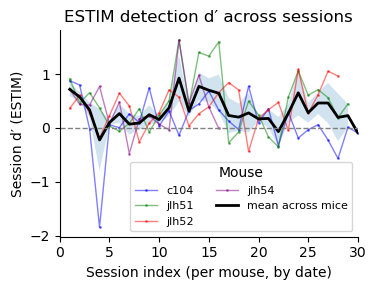

In [534]:
# across session performance (evidence of learning?)

color_map = {"c104": "blue","jlh52": "red","jlh51": "green","jlh54": "purple"}
mice_dfs = [c104_df_filtered_combined, jlh52_df_filtered_combined, jlh51_df_filtered_combined, jlh54_df_filtered_combined]#[c104_single_pulse_df, jlh52_single_pulse_df, jlh51_single_pulse_df, jlh54_single_pulse_df]

def session_dprime(df):
    """compute one d′ for this session; return np.nan if missing pieces"""
    # estim attempts and hits
    stim = df[(df['estim_trial'] == True) & (df['n_pulses'] > 0) & (df['estim_amp_int'].notna()) & (df['estim_amp_int'] != 0)].copy()
    stim = stim[(stim['rewarded']) | (stim['lapse'])]  # attempts
    hits = stim['rewarded'].sum()
    n_stim = len(stim)

    # catch attempts and false alarms
    catch = df.copy()
    catch = catch[(catch['catch_false_alarm']) | (catch['catch_lapse'])]  # attempts
    fas = catch['catch_false_alarm'].sum()
    n_catch = len(catch)

    if n_stim == 0 or n_catch == 0:
        return np.nan

    # log-linear correction
    hr = (hits + 0.5) / (n_stim + 1.0)
    far = (fas + 0.5) / (n_catch + 1.0)
    return norm.ppf(hr) - norm.ppf(far)

# build per-session table
rows = []
for df in mice_dfs:
    d0 = df.copy()

    # start from first estim trial to avoid pre-baseline bias
    d0['trial_tracker'] = np.arange(len(d0))
    first_estim = d0[d0['estim_amp_int'].fillna(0) != 0]['trial_tracker']
    if first_estim.empty:
        continue
    start_idx = first_estim.iloc[0]
    d0 = d0[d0['trial_tracker'] >= start_idx].copy()

    mouseid = d0['mouseid'].iloc[0]
    for date, d_sess in d0.groupby('date', sort=True):
        dp = session_dprime(d_sess)
        rows.append({"mouseid": mouseid, "date": date, "dprime": dp})

sess_df = pd.DataFrame(rows).dropna().sort_values(['mouseid','date']).reset_index(drop=True)


sess_df['session_idx'] = sess_df.groupby('mouseid').cumcount() + 1

agg = (sess_df.groupby('session_idx')['dprime']
       .agg(['mean', 'count', 'std'])
       .rename(columns={'mean':'mean_dp', 'std':'std_dp'}))
agg['sem_dp'] = agg['std_dp'] / np.sqrt(agg['count'].clip(lower=1))


plt.figure(figsize=(4,3))
# per-mouse lines
for m, d in sess_df.groupby('mouseid'):
    plt.plot(d['session_idx'], d['dprime'], marker='o', markersize = 1, lw=1,
             label=m, color=color_map.get(m, None), alpha=0.5)

x = agg.index.values
y = agg['mean_dp'].values
sem = agg['sem_dp'].values
plt.plot(x, y, lw=2, color='black', label='mean across mice')
plt.fill_between(x, y - sem, y + sem, alpha=0.2, edgecolor='none')

# cosmetics
plt.axhline(0, ls='--', color='grey', lw=1)
plt.xlabel('Session index (per mouse, by date)')
plt.ylabel("Session d′ (ESTIM)")
plt.title("ESTIM detection d′ across sessions")
plt.legend(title="Mouse", ncol=2, fontsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 30)
plt.tight_layout()

save_path = 'C:\\Users\\jordan\\Documents\\combined_figs\\behavior'
#plt.savefig(os.path.join('C:\\Users\\jordan\\Documents\\combined_figs\\behavior', 'estim_dprime_across_sessions.png'))
#plt.savefig(os.path.join('C:\\Users\\jordan\\Documents\\combined_figs\\behavior', 'estim_dprime_across_sessions.pdf'))


In [536]:
model_simple = smf.ols("dprime ~ session_idx", data=sess_df).fit()
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:                 dprime   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.116
Date:                Fri, 29 Aug 2025   Prob (F-statistic):              0.293
Time:                        14:20:53   Log-Likelihood:                -81.650
No. Observations:                 117   AIC:                             167.3
Df Residuals:                     115   BIC:                             172.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3868      0.083      4.660      

### OLS regression: session index predicting d′

**Model:**  
\[
d' \sim \text{session index}
\]

**Results:**

| Term         | Coef   | Std.Err | t     | p     | 95% CI (low) | 95% CI (high) |
|--------------|--------|---------|-------|-------|--------------|---------------|
| Intercept    | 0.387  | 0.083   | 4.66  | <0.001 | 0.222        | 0.551         |
| Session idx  | -0.004 | 0.004   | -1.06 | 0.293 | -0.013       | 0.004         |

**Model fit:**  
- \( R^2 = 0.010 \) (very little variance explained)  
- F(1,115) = 1.12, p = 0.293  

**Interpretation:**  
- Baseline session performance is **d′ ≈ 0.39**, significantly above 0.  
- The slope across sessions is **slightly negative (–0.004 d′/session)**, but **not statistically significant (p = 0.29)**.  
- This suggests **no reliable evidence of learning or decline across sessions** in this dataset. Performance appears stable session-to-session.
